# LTSF-Linear

In this project, we create a series of Linear models based on the work, "Are Transformers Effective for Time Series Forecasting," for the task of long-term time series forecasting. We create individual models based on the Linear, NLinear and DLinear models of the paper, and obtain the results on the Appliances Energy Prediction dataset: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction. We conduct the model evaluation for various values of the look-back window and forecasting horizon to achieve valuable insights into the behavior of our model and nature of our dataset.

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Linear Model

In the following cell, we introduce a module corresponding to the vanilla Linear module in the paper. The module accepts positional arguments for the sequence length and prediction length. The sequence length determines the number of entries from the past that are utilized for making a prediction about the future energy appliance values, while the prediction length determines the number of predictions we forecast into the horizon. Additionally, the keyword argument allows us to specify the number of input channels in the dataset for constructing the appropriate number of linear layers for processing each of the dataset features individually.

In [2]:
class Linear(nn.Module):
    def __init__(self, sequence_length, prediction_length, channels=2):
        super(Linear, self).__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.linears = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])

    def forward(self, x):
        out = torch.tensor([], dtype=x.dtype, device=x.device)
        for channel, linear in enumerate(self.linears):
            pred = linear(x[:, :, channel]).unsqueeze(-1)
            out = torch.cat([out, pred], dim=-1)
        return out

### Dataset

In the following cell, we create an ApplianceEnergyUsageDataset for us by our Linear model for the energy appliance usage time-series forecasting problem. In addition, we also include utility functions in get_train_dataset and get_test_dataset for obtaining separate training and testing datasets for our Linear model. We split the dataset by reserving the first 80% of samples for the model training, while the remaining 20% of the samples are used for model testing. As per described by the literature, normalization is applied to scale the test data by the mean and variance of the training data for helping to improve model performance.

In [3]:
class ApplianceEnergyUsageDataset(Dataset):
    def __init__(self, energy_data, sequence_length, prediction_length):
        super().__init__()
        self.energy_data = energy_data
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length        

    def __getitem__(self, index):
        sequence_begin = index
        sequence_end = sequence_begin + self.sequence_length
        x = self.energy_data[sequence_begin:sequence_end]
        prediction_begin = sequence_end
        prediction_end = prediction_begin + self.prediction_length
        y = self.energy_data[prediction_begin:prediction_end]
        return x, y

    def __len__(self):
        return len(self.energy_data) - self.sequence_length - self.prediction_length + 1


energy_data_file = '../../datasets/appliances_energy_prediction/energydata_complete.csv'
energy_data = pd.read_csv(energy_data_file, usecols=[0, 1, 2])
training_samples = int(len(energy_data) * 0.8)
scaler = StandardScaler()
train_data = scaler.fit_transform(energy_data.iloc[:training_samples, 1:].values)

def get_train_dataset(sequence_length, prediction_length):
    dataset = ApplianceEnergyUsageDataset(train_data, 
                                          sequence_length, 
                                          prediction_length)
    return dataset

def get_test_dataset(sequence_length, prediction_length):
    test_data = scaler.transform(energy_data.iloc[
        training_samples - sequence_length:, 1:].values)
    dataset = ApplianceEnergyUsageDataset(test_data,
                                          sequence_length,
                                          prediction_length)
    return dataset

## Model Training/Evaluation

In the following cells, we obtain the model loss statistics in MSE between target and predicted values on the test dataset for varying values of the sequence and prediction length. We evalute the model for different combinations of sequence length {24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672, 720} (corresponding to 4, 8, 12, 16, 20, 24, 28, 32, 56, 84, 112 or 120 hours) and forecasting steps {24, 720} (corresponding to 4 or 120 hours).

In [4]:
# We define the train and test functions below for training and testing our model, respectively:
def train(dataloader, model, criterion, optimizer):
    model.train()
    for X, y in dataloader:
        X, y = [_.to(torch.float32).to(device) for _ in (X, y,)]
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(dataloader, model, criterion):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = [_.to(torch.float32).to(device) for _ in (X, y,)]
            pred = model(X)
            test_loss += criterion(pred, y).item()
    test_loss /= num_batches
    return test_loss

Next, we iterate through all the possible combinations of forecasting steps and look-back window sizes to find the optimal value for minimizing model loss on the test dataset. Generally speaking, larger look-back window sizes usually result in more accurate predictions, but we do want to verify the results empirically for determining which values work best for the dataset.

In [5]:
BATCH_SIZE = 64
FORECASTING_STEPS = [24, 36, 48, 60, 96, 192, 336, 720]
LOOKBACK_WINDOW_SIZES = [24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672, 720]

# We define the get_loss_data function for retrieving model loss on the test dataset for the various combinations of sequence length and prediction length
def get_loss_data(model_class):
    loss_data = {'Prediction Length': [], 'Sequence Length': [], 'Avg Loss': [], 'Model': []}
    for pred_length in FORECASTING_STEPS:
        for seq_length in LOOKBACK_WINDOW_SIZES:
            train_dataset = get_train_dataset(seq_length, pred_length)
            test_dataset = get_test_dataset(seq_length, pred_length)
            train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
            test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
            model = model_class(seq_length, pred_length).to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            epochs = 10
            for epoch in range(epochs):
                train(train_dataloader, model, criterion, optimizer)
            test_loss = test(test_dataloader, model, criterion)
            loss_data['Avg Loss'].append(test_loss)
            loss_data['Prediction Length'].append(pred_length)
            loss_data['Sequence Length'].append(seq_length)
            loss_data['Model'].append(model_class.__name__)
    return loss_data

## Visualize Results

In the following cell output, we visualize model loss for each of the configurations for the sequence length and prediction horizon used for training and testing the model. The model loss is determined in MSE between target and predicted values for each of the appliances in the test dataset.

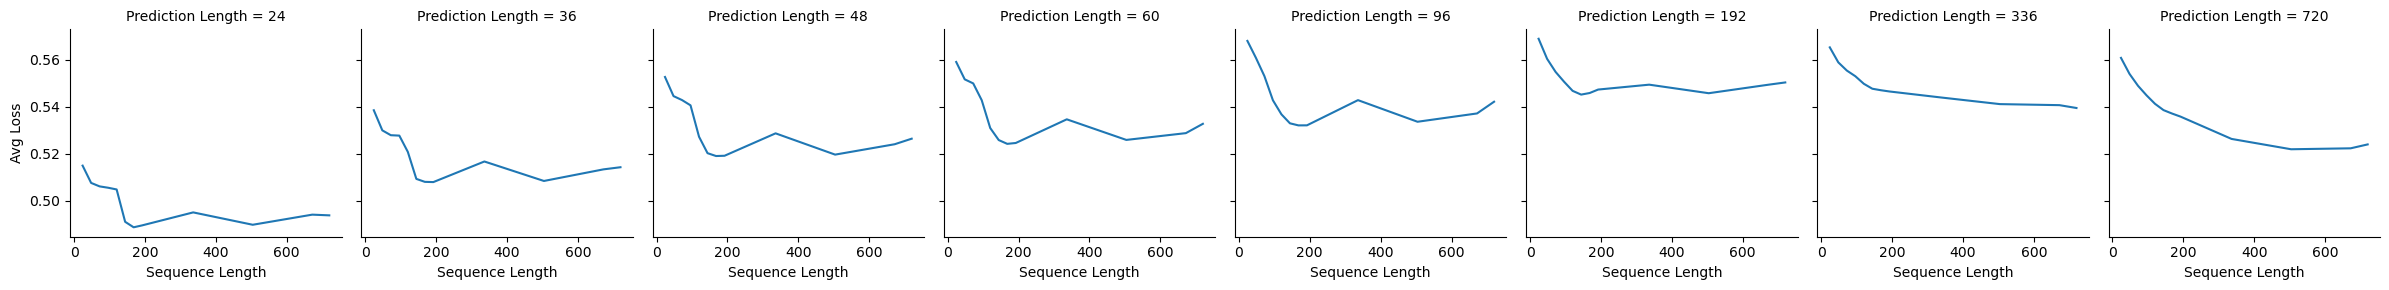

In [6]:
# visualizing the results for model loss using seaborn.FacetGrid
loss_data = get_loss_data(Linear)
df_losses = pd.DataFrame(loss_data)
g = sns.FacetGrid(df_losses, col='Prediction Length')
g.map(sns.lineplot, 'Sequence Length', 'Avg Loss')

Based on the output from the previous cell, we can confirm that higher values of the sequence length typically result in improved predictions of energy appliance usage in the dataset. However, there is a distinct pattern noticeable for the graphs below a prediction length threshold of 192 (32 hours) in which the model performance seems to degrade slightly with the sequence lengths ranging from 200 (\~33 hours) and 400 (\~66 hours). This may be due to the greater variability in energy appliance usage occurring during the course of a week or few days, but tending to become more predictable for longer time horizons by exhibiting certain trends with more regularity.

### NLinear Model

Since we normalize test data by the mean and variance of the training data, there is a potential for the mean value of the test data to not be 0. Large errors could occur if the model makes a prediction that is out of distribution of the true value. In the following experiment, we introduce a new model, NLinear, that shifts the model prediction towards the distribution of true value by subtracting and adding the last value of the input sequence.

In [7]:
class NLinear(nn.Module):
    def __init__(self, sequence_length, prediction_length, channels=2):
        super(NLinear, self).__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.linears = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])

    def forward(self, x):
        out = torch.tensor([], dtype=x.dtype, device=x.device)
        seq_last = x[:, -1:, :].detach()
        x = x - seq_last
        for channel, linear in enumerate(self.linears):
            pred = linear(x[:, :, channel]).unsqueeze(-1)
            out = torch.cat([out, pred], dim=-1)
        out = out + seq_last
        return out

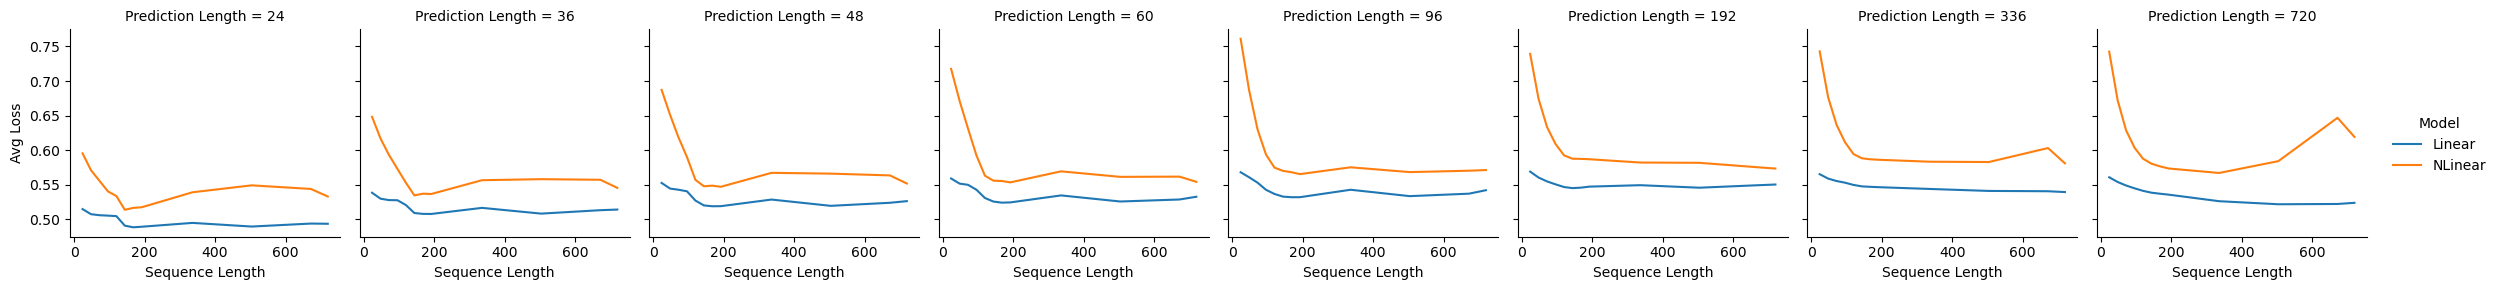

In [8]:
for key, values in get_loss_data(NLinear).items():
    loss_data[key] += values
df_losses = pd.DataFrame(loss_data)
g = sns.FacetGrid(df_losses, col='Prediction Length', hue='Model')
g.map(sns.lineplot, 'Sequence Length', 'Avg Loss')
g.add_legend()

Based on the result above, it is probably safe to assume that there does not exist a substantial distribution shift between the training and testing data. Therefore, the adjustments applied in subtracting and adding the last value of the input sequence presumably were not necessary, and have lead to poorer performing model. This allows us to infer that potential the energy appliance usage in the dataset takes on values that are relatively more stable over time, and do not vary exceedingly between the training and testing datasets.

### DLinear Model

For the DLinear model, we first decompose the raw input data into a trend component by a moving average kernel and a remainder (seasonal) component, then apply two linear layers to each component and sum the feature vectors together to obtain a final prediction. We believe that by explicitly handling trend in DLinear model, that we will be able to improve upon our vanilla Linear model by explicitly capturing patterns related to long-term trends or seasonality of the appliance energy usage.

In [9]:
class MovingAverage(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MovingAverage, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = MovingAverage(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    def __init__(self, sequence_length, prediction_length, channels=2):
        super(DLinear, self).__init__()
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.decomposition = SeriesDecomposition(25)
        self.seasonal = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])
        self.trend = nn.ModuleList([
            nn.Linear(sequence_length, prediction_length)
            for _ in range(channels)
        ])        

    def forward(self, x):
        x_seasonal, x_trend = self.decomposition(x)
        seasonal_out = torch.tensor([], dtype=x_seasonal.dtype, device=x_seasonal.device)
        for channel, linear in enumerate(self.seasonal):
            pred = linear(x_seasonal[:, :, channel]).unsqueeze(-1)
            seasonal_out = torch.cat([seasonal_out, pred], dim=-1)
        trend_out = torch.tensor([], dtype=x_trend.dtype, device=x_trend.device)
        for channel, linear in enumerate(self.trend):
            pred = linear(x_trend[:, :, channel]).unsqueeze(-1)
            trend_out = torch.cat([trend_out, pred], dim=-1)
        out = seasonal_out + trend_out
        return out

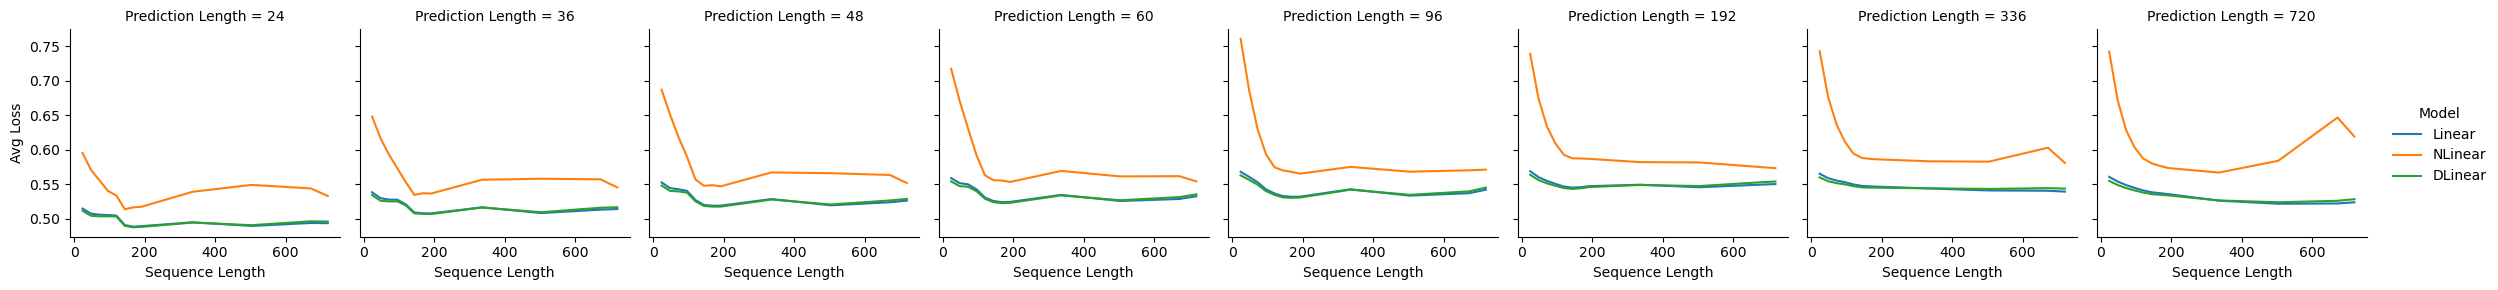

In [10]:
for key, values in get_loss_data(DLinear).items():
    loss_data[key] += values
df_losses = pd.DataFrame(loss_data)
g = sns.FacetGrid(df_losses, col='Prediction Length', hue='Model')
g.map(sns.lineplot, 'Sequence Length', 'Avg Loss')
g.add_legend()

Our DLinear model seems to perform on par with the vanilla Linear model, indicating that perhaps such a trend decomposition scheme is not necessary for our dataset, or that our Linear model is sufficient to capture the trends without any additional linear layers. 